# Brain Tumor Classification Using EfficientNetB0

In [2]:
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm

## Data Preprocessing

In [4]:
# Define constants
image_size = 150
labels = ['glioma_tumor', 'no_tumor', 'meningioma_tumor', 'pituitary_tumor']
data_dir = "Brain-Tumor-Classification-DataSet"

# Load and preprocess data
X, y = [], []
for label in labels:
    folderPath = os.path.join(data_dir, 'Training', label)
    for img_file in tqdm(os.listdir(folderPath)):
        img = cv2.imread(os.path.join(folderPath, img_file))
        img = cv2.resize(img, (image_size, image_size))
        X.append(img)
        y.append(label)

X = np.array(X) / 255.0  # Normalize pixel values
y = np.array(y)

# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)
y = to_categorical(y)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

# Compute class weights
class_weights = compute_class_weight('balanced', classes=np.unique(np.argmax(y, axis=1)), y=np.argmax(y, axis=1))
class_weights = dict(enumerate(class_weights))

100%|████████████████████████████████████████| 827/827 [00:12<00:00, 65.35it/s]


## Model Definition and Training

In [11]:
# Define model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(image_size, image_size, 3))
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(len(labels), activation='softmax')
])

# Compile model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-5),
    ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
]

# Train model
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32,
    class_weight=class_weights,
    callbacks=callbacks
)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 167s 1s/step - accuracy: 0.7567 - loss: 0.6399 - val_accuracy: 0.1533 - val_loss: 2.3616 - learning_rate: 0.0010
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9199 - loss: 0.2072 - val_accuracy: 0.1533 - val_loss: 2.1027 - learning_rate: 0.0010
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9158 - loss: 0.2380 - val_accuracy: 0.1533 - val_loss: 3.4735 - learning_rate: 0.0010
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 98s 1s/step - accuracy: 0.9629 - loss: 0.0946 - val_accuracy: 0.1533 - val_loss: 6.0985 - learning_rate: 0.0010
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 100s 1s/step - accuracy: 0.9701 - loss: 0.0864 - val_accuracy: 0.1533 - val_loss: 7.9160 - learning_rate: 0.0010
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - accuracy: 0.9856 - loss: 0.0392 - val_accuracy: 0.1533 - val_loss: 8.6373 - learning_rate: 2.0000e-04
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 95s 1s/step - accuracy: 0.9952 - loss: 0.0157 - val_accu

## Model Evaluation

In [13]:
# Evaluate model
val_loss, val_accuracy = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}")

# Save model
model.save('brain_tumor_classifier.h5')

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.1372 - loss: 2.0943


Validation Loss: 2.1026740074157715, Validation Accuracy: 0.15331010520458221


## Visualization of Training Progress

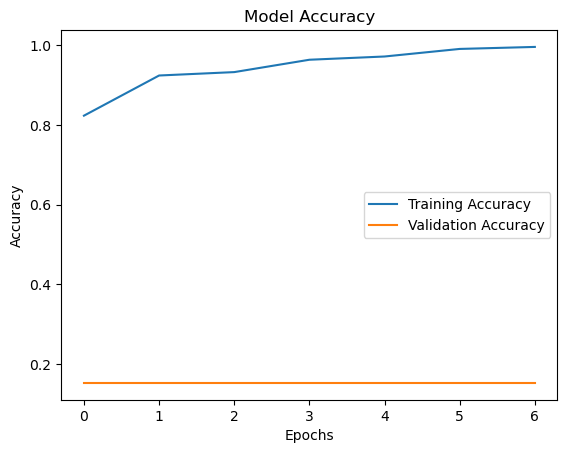

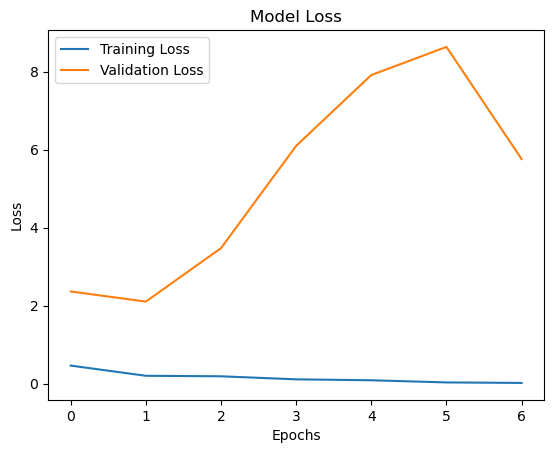

In [15]:
# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test Inference Example

In [ ]:
import cv2
import numpy as np
import os

def predict_image_from_path(model, image_path, label_encoder, image_size):
    """
    Predict the label of an image given its path.

    Args:
        model: Trained model to use for prediction.
        image_path: Path to the image to predict.
        label_encoder: Label encoder used to decode predicted labels.
        image_size: Size to which the image should be resized.

    Returns:
        The predicted label.
    """
    try:
        # Load and preprocess the image
        img = cv2.imread(image_path)
        if img is None:
            raise ValueError(f"Could not read the image from {image_path}. Check the file path.")
        
        img = cv2.resize(img, (image_size, image_size))
        img = img / 255.0  # Normalize the image
        img = np.expand_dims(img, axis=0)  # Add batch dimension
        
        # Make prediction
        pred = model.predict(img)
        predicted_class = label_encoder.inverse_transform([np.argmax(pred)])
        
        return predicted_class[0]
    except Exception as e:
        return str(e)

# Example usage
example_image_path = "path/to/your/image.jpg"  # Replace with the actual image path
predicted_label = predict_image_from_path(model, example_image_path, label_encoder, image_size=128)  # Adjust `image_size` if needed
print(f"Predicted Label: {predicted_label}")